In [ ]:
!pip install transformers

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=4ab126b4d9e30fad21d49e5290568e58260950595c4395e5667fde5f3cbb2661
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import glob
import pandas as pd
import csv
import re
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModel, AdamW
import torch

import fasttext
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import pandas as pd
import json

In [ ]:
def transform_column(df_column):
  scaler = MinMaxScaler()
  scores = np.array(df_column)
  scores = scores.reshape(-1,1)
  scaler.fit(scores)
  scores = scaler.transform(scores)
  scores = np.float32(scores)
  return scores

In [ ]:
model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
model = fasttext.load_model(model_path)

def is_romanian_post(row):
  if model.predict(change_n_to_space(row["title"]))[0][0] == '__label__ron_Latn':
      return True
  return False

def change_n_to_space(text):
  return text.replace('\n', ' ')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.bin:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [ ]:
df_romania = pd.read_json('Romania_submissions (1).json',orient='index')
df_romania = df_romania.reset_index()
df_romania = df_romania.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})
df_romania['num_comments'] = transform_column(df_romania['num_comments'])
df_romania['score'] = transform_column(df_romania['score'])
df_romania

,title,content,num_comments,score,date
0,"Romania declares witchcraft a profession, FINA...",,0.013095,0.056034,2011-01-04 23:51:48
1,I'm an American who is about to Study Abroad i...,I'll be attending Babes-Bolyai this coming sem...,0.020238,0.036638,2011-01-06 07:31:18
2,Dead birds were dead drunk,,0.002381,0.049569,2011-01-13 14:43:21
3,RObotzi - serial animat romanesc,,0.010714,0.032328,2011-01-24 02:26:07
4,Paraziții - În Jur (altă variantă decât cea de...,,0.004762,0.028017,2011-01-26 13:26:21
...,...,...,...,...,...
29995,Hai sa facem un exercitiu de democratie. Vreti...,,0.004762,0.000000,2015-05-22 00:00:30
29996,[Rant] Prietenul m-a parasit din cauza religie...,Am avut un prieten timp de cateva zile de care...,0.164286,0.062500,2015-05-22 00:10:53
29997,Unui român care nu s-a mai bărbierit din ianua...,,0.000000,0.071121,2015-05-22 04:55:23
29998,Soluţie tipic românească. Medicamentele fără r...,,0.004762,0.051724,2015-05-22 08:21:00


In [ ]:
df_romania = df_romania[df_romania.apply(is_romanian_post, axis=1)]
df_romania['full_text'] = df_romania['title'] + ' ' + df_romania['content']
df_romania['sum_score'] = df_romania['num_comments'] + df_romania['score']
df_romania

<ipython-input-10-d26c9d8f3924>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_romania['full_text'] = df_romania['title'] + ' ' + df_romania['content']
<ipython-input-10-d26c9d8f3924>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_romania['sum_score'] = df_romania['num_comments'] + df_romania['score']


,title,content,num_comments,score,date,full_text,sum_score
3,RObotzi - serial animat romanesc,,0.010714,0.032328,2011-01-24 02:26:07,RObotzi - serial animat romanesc,0.043042
4,Paraziții - În Jur (altă variantă decât cea de...,,0.004762,0.028017,2011-01-26 13:26:21,Paraziții - În Jur (altă variantă decât cea de...,0.032779
6,Muzica romaneasca.......Ce-au trecut anii........,,0.020238,0.034483,2011-01-30 23:46:30,Muzica romaneasca.......Ce-au trecut anii........,0.054721
7,Muzica romaneasca de top-ce au trecut anii.......,,0.004762,0.028017,2011-01-30 23:28:51,Muzica romaneasca de top-ce au trecut anii.......,0.032779
8,Grigorescu Eva Maria,,0.002381,0.008621,2011-02-01 01:37:08,Grigorescu Eva Maria,0.011002
...,...,...,...,...,...,...,...
29994,UE pare să piardă lupta cu Rusia pentru Republ...,,0.009524,0.043103,2015-05-21 23:40:49,UE pare să piardă lupta cu Rusia pentru Republ...,0.052627
29996,[Rant] Prietenul m-a parasit din cauza religie...,Am avut un prieten timp de cateva zile de care...,0.164286,0.062500,2015-05-22 00:10:53,[Rant] Prietenul m-a parasit din cauza religie...,0.226786
29997,Unui român care nu s-a mai bărbierit din ianua...,,0.000000,0.071121,2015-05-22 04:55:23,Unui român care nu s-a mai bărbierit din ianua...,0.071121
29998,Soluţie tipic românească. Medicamentele fără r...,,0.004762,0.051724,2015-05-22 08:21:00,Soluţie tipic românească. Medicamentele fără r...,0.056486


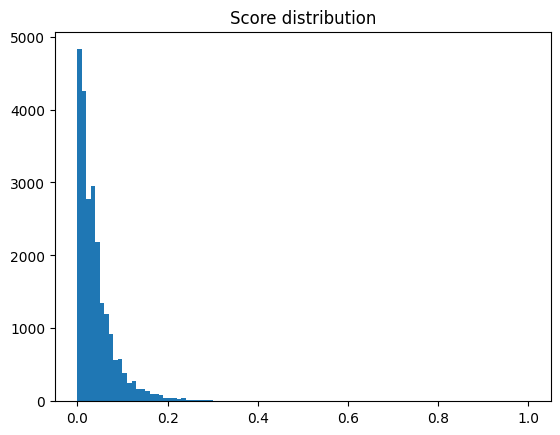

In [ ]:
plt.hist(df_romania['score'], bins=100)
plt.title('Score distribution')
plt.show()

In [ ]:
df_cluj = pd.read_json('cluj_submissions (1).json',orient='index')
df_cluj = df_cluj.reset_index()
df_cluj = df_cluj.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})
df_cluj['num_comments'] = transform_column(df_cluj['num_comments'])
df_cluj['score'] = transform_column(df_cluj['score'])
df_cluj

,title,content,num_comments,score,date
0,"Gheorgheni, in seara asta",,0.248322,1.000000,2023-10-06 22:49:39
1,"As a german, I cannot believe this",,0.432886,0.762408,2022-10-01 20:03:37
2,Conversatie cu vecinul de jos pe care nici nu ...,,0.412752,0.733896,2023-05-30 10:05:32
3,"Buna ziua, suntem studenti UMF Medicina dentar...",Oferim următoarele servicii:\n-Consultații\n-D...,0.312081,0.665259,2023-10-12 09:11:34
4,Intre timp apartamentele din Cluj:,,0.036913,0.652587,2022-02-10 09:00:32
...,...,...,...,...,...
975,"Cel mai curat,linistit, lipsit de poluare cart...",,0.120805,0.001056,2022-08-23 20:44:32
976,Salutare! Îmi puteți recomanda un ONG prin Clu...,,0.036913,0.001056,2022-06-13 23:07:00
977,Consultant financiar personal?,Tot ce gasesc pe google sunt firme de contabil...,0.083893,0.001056,2022-01-30 08:44:03
978,Cum dau de un baiat de la Pata Rat?,"Salut,\n\n&#x200B;\n\nStau in Mihai Viteazu si...",0.070470,0.000000,2021-10-26 17:35:40


In [ ]:
df_cluj = df_cluj[df_cluj.apply(is_romanian_post, axis=1)]
df_cluj['sum_score'] = df_cluj['num_comments'] + df_cluj['score']
df_cluj['full_text'] = df_cluj['title'] + ' ' + df_cluj['content']
df_cluj

<ipython-input-13-11ad1e4d8d16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluj['sum_score'] = df_cluj['num_comments'] + df_cluj['score']
<ipython-input-13-11ad1e4d8d16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluj['full_text'] = df_cluj['title'] + ' ' + df_cluj['content']


,title,content,num_comments,score,date,sum_score,full_text
0,"Gheorgheni, in seara asta",,0.248322,1.000000,2023-10-06 22:49:39,1.248322,"Gheorgheni, in seara asta"
2,Conversatie cu vecinul de jos pe care nici nu ...,,0.412752,0.733896,2023-05-30 10:05:32,1.146648,Conversatie cu vecinul de jos pe care nici nu ...
3,"Buna ziua, suntem studenti UMF Medicina dentar...",Oferim următoarele servicii:\n-Consultații\n-D...,0.312081,0.665259,2023-10-12 09:11:34,0.977339,"Buna ziua, suntem studenti UMF Medicina dentar..."
4,Intre timp apartamentele din Cluj:,,0.036913,0.652587,2022-02-10 09:00:32,0.689500,Intre timp apartamentele din Cluj:
5,Ceva titlu,,0.093960,0.616684,2022-11-18 12:37:28,0.710644,Ceva titlu
...,...,...,...,...,...,...,...
972,De ce proprietarii vând doar prin agenții?,Căutând prin anunțurile imobiliare observ că 9...,0.154362,0.001056,2022-10-01 19:07:24,0.155418,De ce proprietarii vând doar prin agenții? Cău...
974,"Cei care faceti sala, ce sala imi puteti recom...",As vrea sa ma apuc si eu de sala si nu stiu la...,0.255034,0.001056,2022-08-27 17:32:24,0.256090,"Cei care faceti sala, ce sala imi puteti recom..."
975,"Cel mai curat,linistit, lipsit de poluare cart...",,0.120805,0.001056,2022-08-23 20:44:32,0.121861,"Cel mai curat,linistit, lipsit de poluare cart..."
976,Salutare! Îmi puteți recomanda un ONG prin Clu...,,0.036913,0.001056,2022-06-13 23:07:00,0.037969,Salutare! Îmi puteți recomanda un ONG prin Clu...


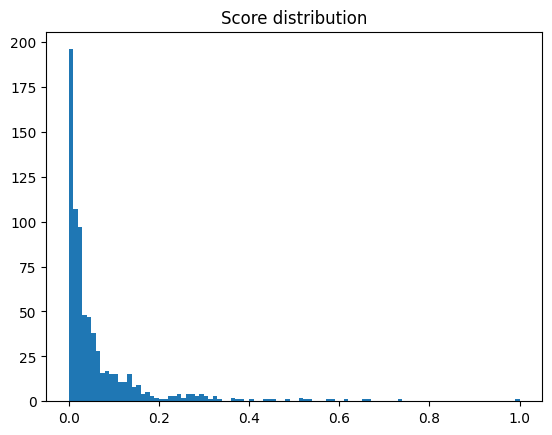

In [ ]:
plt.hist(df_cluj['score'], bins=100)
plt.title('Score distribution')
plt.show()

In [ ]:
df_bucuresti = pd.read_json('bucuresti_submissions (1).json',orient='index')
df_bucuresti = df_bucuresti.reset_index()
df_bucuresti = df_bucuresti.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})
df_bucuresti['num_comments'] = transform_column(df_bucuresti['num_comments'])
df_bucuresti['score'] = transform_column(df_bucuresti['score'])
df_bucuresti

,title,content,num_comments,score,date
0,Help Finding Vaguely Described Place,"""Long story short, I've found recently that in...",0.005780,0.000880,2018-01-08 15:33:19
1,Looking for a shisha shop,I just moved to Bucharest and I'm a big shisha...,0.009634,0.000880,2018-01-17 15:00:13
2,Consiliul General al Municipiului București a ...,Alte două linii de tramvai din București vor f...,0.001927,0.001759,2018-03-28 15:17:54
3,Need Help!,"Hello, \n\nMe and some friends are visiting Bu...",0.005780,0.000000,2018-04-01 15:23:38
4,Dutch soccer team looking for friendly match i...,We are a Dutch amateur soccer team visiting Bu...,0.001927,0.001759,2018-04-06 12:30:03
...,...,...,...,...,...
2910,Călugărițe...,"Care e treaba cu călugărițele, și ma refer la ...",0.069364,0.036060,2023-08-27 22:36:48
2911,"""Mi-a spus foarte clar, 150 lei/km"". Șoferii d...",,0.042389,0.034301,2023-08-20 09:02:23
2912,Povestioară,Ma scuzați pentru lunga poveste care urmează....,0.001927,0.035180,2023-06-30 18:48:06
2913,Acum 5 zile v-am scris despre situatia unui tr...,,0.023121,0.033421,2023-05-25 10:13:23


In [ ]:
df_bucuresti = df_bucuresti[df_bucuresti.apply(is_romanian_post, axis=1)]
df_bucuresti['sum_score'] = df_bucuresti['num_comments'] + df_bucuresti['score']
df_bucuresti['full_text'] = df_bucuresti['title'] + ' ' + df_bucuresti['content']
df_bucuresti

<ipython-input-16-5a72ba73a645>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bucuresti['sum_score'] = df_bucuresti['num_comments'] + df_bucuresti['score']
<ipython-input-16-5a72ba73a645>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bucuresti['full_text'] = df_bucuresti['title'] + ' ' + df_bucuresti['content']


,title,content,num_comments,score,date,sum_score,full_text
2,Consiliul General al Municipiului București a ...,Alte două linii de tramvai din București vor f...,0.001927,0.001759,2018-03-28 15:17:54,0.003686,Consiliul General al Municipiului București a ...
12,Harta magazinelor de biciclism din Bucuresti,https://imgur.com/iSzwLtR,0.011561,0.004398,2018-06-28 18:16:55,0.015958,Harta magazinelor de biciclism din Bucuresti h...
15,Turista pentru 2 zile/ looking for a guide,Salut. Stau in București pentru următoarele 2 ...,0.001927,0.000880,2018-07-16 20:44:40,0.002806,Turista pentru 2 zile/ looking for a guide Sal...
16,Giulesti miroase a rahat,Hey! De cateva zile in zona Giulesti abia se p...,0.013487,0.003518,2018-07-17 07:37:10,0.017006,Giulesti miroase a rahat Hey! De cateva zile i...
21,Tractare Autovehicul Bucuresti,"Salut,\n\nPoate cineva sa-mi recomande o firma...",0.001927,0.002639,2018-08-18 12:35:02,0.004565,"Tractare Autovehicul Bucuresti Salut,\n\nPoate..."
...,...,...,...,...,...,...,...
2910,Călugărițe...,"Care e treaba cu călugărițele, și ma refer la ...",0.069364,0.036060,2023-08-27 22:36:48,0.105424,"Călugărițe... Care e treaba cu călugărițele, ș..."
2911,"""Mi-a spus foarte clar, 150 lei/km"". Șoferii d...",,0.042389,0.034301,2023-08-20 09:02:23,0.076690,"""Mi-a spus foarte clar, 150 lei/km"". Șoferii d..."
2912,Povestioară,Ma scuzați pentru lunga poveste care urmează....,0.001927,0.035180,2023-06-30 18:48:06,0.037107,Povestioară Ma scuzați pentru lunga poveste c...
2913,Acum 5 zile v-am scris despre situatia unui tr...,,0.023121,0.033421,2023-05-25 10:13:23,0.056543,Acum 5 zile v-am scris despre situatia unui tr...


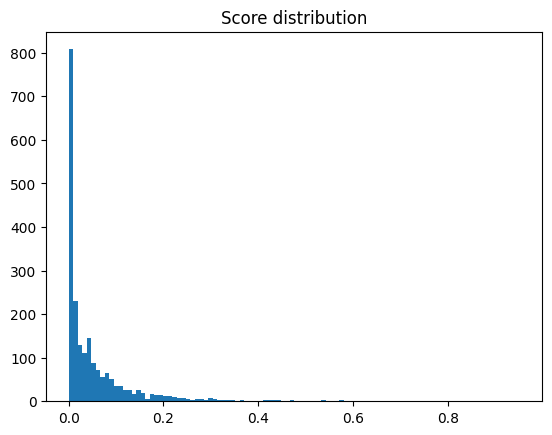

In [ ]:
plt.hist(df_bucuresti['score'], bins=100)
plt.title('Score distribution')
plt.show()

In [ ]:
df_iasi = pd.read_json('iasi_submissions (1).json',orient='index')
df_iasi = df_iasi.reset_index()
df_iasi = df_iasi.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})
df_iasi['num_comments'] = transform_column(df_iasi['num_comments'])
df_iasi['score'] = transform_column(df_iasi['score'])
df_iasi

,title,content,num_comments,score,date
0,"Daca dispar, continuati ce am inceput",,0.153086,1.000000,2023-09-14 17:41:55
1,De unde tot apar vacile astea?,,0.217284,0.855422,2023-09-22 17:12:39
2,Am gasit pisica! Va multumesc mult tuturor! A ...,,0.061728,0.561747,2023-03-26 21:14:54
3,O bijuterie intr-o parcare din Iasi. Va place?,,0.051852,0.548193,2022-04-23 17:08:13
4,Vanzare de vape-uri cu nicotina minorilor.,"Iași, zona Palas, chiar în fața hotelului Mold...",0.204938,0.540663,2023-09-18 23:51:17
...,...,...,...,...,...
959,Pe 9 septembrie se organizeaza o noua editie A...,,0.000000,0.001506,2023-09-06 16:55:05
960,Clinica medicala de la USV Iasi?,Buna. A fost cineva cu animalutul la clinica m...,0.046914,0.003012,2023-08-31 11:45:34
961,Sesizări online,Salutare! \nA folosit cineva (cu succes) pagin...,0.049383,0.001506,2023-08-30 17:10:46
962,Casa in Iasi,Nu stiu daca asta este locul potrivit but Im g...,0.044444,0.000000,2023-08-29 14:55:34


In [ ]:
df_iasi = df_iasi[df_iasi.apply(is_romanian_post, axis=1)]
df_iasi['sum_score'] = df_iasi['num_comments'] + df_iasi['score']
df_iasi['full_text'] = df_iasi['title'] + ' ' + df_iasi['content']
df_iasi

<ipython-input-19-d4e5fc40c200>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iasi['sum_score'] = df_iasi['num_comments'] + df_iasi['score']
<ipython-input-19-d4e5fc40c200>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iasi['full_text'] = df_iasi['title'] + ' ' + df_iasi['content']


,title,content,num_comments,score,date,sum_score,full_text
0,"Daca dispar, continuati ce am inceput",,0.153086,1.000000,2023-09-14 17:41:55,1.153086,"Daca dispar, continuati ce am inceput"
1,De unde tot apar vacile astea?,,0.217284,0.855422,2023-09-22 17:12:39,1.072706,De unde tot apar vacile astea?
2,Am gasit pisica! Va multumesc mult tuturor! A ...,,0.061728,0.561747,2023-03-26 21:14:54,0.623475,Am gasit pisica! Va multumesc mult tuturor! A ...
3,O bijuterie intr-o parcare din Iasi. Va place?,,0.051852,0.548193,2022-04-23 17:08:13,0.600045,O bijuterie intr-o parcare din Iasi. Va place?
4,Vanzare de vape-uri cu nicotina minorilor.,"Iași, zona Palas, chiar în fața hotelului Mold...",0.204938,0.540663,2023-09-18 23:51:17,0.745601,Vanzare de vape-uri cu nicotina minorilor. Iaș...
...,...,...,...,...,...,...,...
955,Cumpărat apartament fără agenții,Salutare!\n\nAm și eu de gând să cumpăr un apa...,0.019753,0.001506,2023-09-22 17:27:53,0.021259,Cumpărat apartament fără agenții Salutare!\n\n...
959,Pe 9 septembrie se organizeaza o noua editie A...,,0.000000,0.001506,2023-09-06 16:55:05,0.001506,Pe 9 septembrie se organizeaza o noua editie A...
960,Clinica medicala de la USV Iasi?,Buna. A fost cineva cu animalutul la clinica m...,0.046914,0.003012,2023-08-31 11:45:34,0.049926,Clinica medicala de la USV Iasi? Buna. A fost ...
961,Sesizări online,Salutare! \nA folosit cineva (cu succes) pagin...,0.049383,0.001506,2023-08-30 17:10:46,0.050889,Sesizări online Salutare! \nA folosit cineva (...


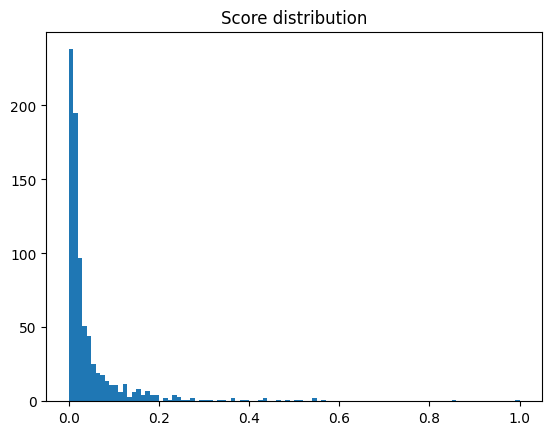

In [ ]:
plt.hist(df_iasi['score'], bins=100)
plt.title('Score distribution')
plt.show()

In [ ]:
df_timisoara = pd.read_json('timisoara_submissions (1).json',orient='index')
df_timisoara = df_timisoara.reset_index()
df_timisoara = df_timisoara.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})
df_timisoara['num_comments'] = transform_column(df_timisoara['num_comments'])
df_timisoara['score'] = transform_column(df_timisoara['score'])
df_timisoara

,title,content,num_comments,score,date
0,Steag LGBT lângă steagul României la noul IKEA...,Păreri?,1.000000,1.000000,2023-05-17 10:59:12
1,Uite ca se poate!!!,,0.065649,0.771580,2023-09-25 13:47:47
2,În caz că vreți să vă angajați la New Yorker î...,Mi-am dat azi demisia și aici am o listă de mo...,0.254962,0.709163,2023-08-31 02:16:38
3,"Timișoara o să devină mai verde, modernă și ma...",,0.178626,0.622842,2023-10-16 18:08:04
4,De ce downgrade?,Aveam și noi o fântână fain decorată 😑,0.065649,0.564409,2023-06-05 14:48:18
...,...,...,...,...,...
973,Escape tonight?,,0.016794,0.001328,2023-04-01 18:27:49
974,Spatiu munca remote 1 zi,Salut. Ma voi afla vineri in Timișoara si am n...,0.018321,0.000000,2023-03-21 06:52:51
975,Stie cineva o locatie de unde se pot inchiria ...,,0.007634,0.002656,2023-03-15 11:34:27
976,PUZ in dezbatere publica a zonei dintre str Oi...,,0.000000,0.001328,2023-03-14 16:53:02


In [ ]:
df_timisoara = df_timisoara[df_timisoara.apply(is_romanian_post, axis=1)]
df_timisoara['sum_score'] = df_timisoara['num_comments'] + df_timisoara['score']
df_timisoara['full_text'] = df_timisoara['title'] + ' ' + df_timisoara['content']
df_timisoara

<ipython-input-22-808a8cc14776>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timisoara['sum_score'] = df_timisoara['num_comments'] + df_timisoara['score']
<ipython-input-22-808a8cc14776>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timisoara['full_text'] = df_timisoara['title'] + ' ' + df_timisoara['content']


,title,content,num_comments,score,date,sum_score,full_text
0,Steag LGBT lângă steagul României la noul IKEA...,Păreri?,1.000000,1.000000,2023-05-17 10:59:12,2.000000,Steag LGBT lângă steagul României la noul IKEA...
1,Uite ca se poate!!!,,0.065649,0.771580,2023-09-25 13:47:47,0.837229,Uite ca se poate!!!
2,În caz că vreți să vă angajați la New Yorker î...,Mi-am dat azi demisia și aici am o listă de mo...,0.254962,0.709163,2023-08-31 02:16:38,0.964125,În caz că vreți să vă angajați la New Yorker î...
3,"Timișoara o să devină mai verde, modernă și ma...",,0.178626,0.622842,2023-10-16 18:08:04,0.801468,"Timișoara o să devină mai verde, modernă și ma..."
5,Soferii de la Tucano Cafe,,0.105344,0.416999,2023-05-05 18:26:17,0.522342,Soferii de la Tucano Cafe
...,...,...,...,...,...,...,...
970,Locuri de muncă - limba poloneză,Hello! Poate mă puteți ajuta cu o sugestie. Av...,0.009160,0.001328,2023-04-20 12:57:35,0.010488,Locuri de muncă - limba poloneză Hello! Poate ...
971,Recomandare firma de curatenie/femeie de servici,As avea nevoie de ajutor pt spalat geamuri + c...,0.007634,0.001328,2023-04-04 22:22:20,0.008962,Recomandare firma de curatenie/femeie de servi...
972,Nouă galerie comercială în construcție la intr...,,0.004580,0.000000,2023-04-03 04:46:58,0.004580,Nouă galerie comercială în construcție la intr...
975,Stie cineva o locatie de unde se pot inchiria ...,,0.007634,0.002656,2023-03-15 11:34:27,0.010290,Stie cineva o locatie de unde se pot inchiria ...


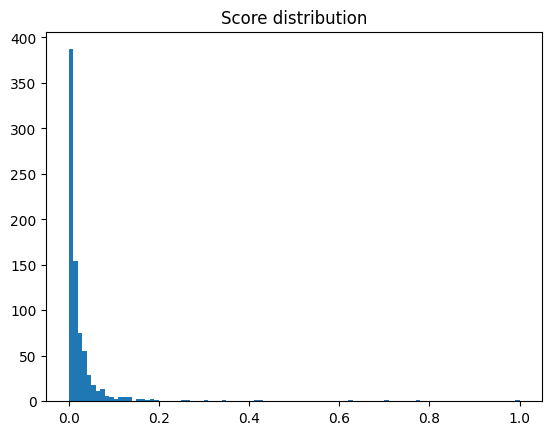

In [ ]:
plt.hist(df_timisoara['score'], bins=100)
plt.title('Score distribution')
plt.show()

In [ ]:
df_train = df_romania
df_test = pd.concat([df_cluj, df_iasi, df_timisoara], ignore_index=True)
df_validation = pd.concat([df_bucuresti], ignore_index=True)

In [ ]:
# Load the dataset into a pandas dataframe.

df_train = shuffle(df_train)
df_validation = shuffle(df_validation)
df_test = shuffle(df_test)

print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print('Number of validation sentences: {:,}\n'.format(df_validation.shape[0]))
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Display 10 random rows from the data.
df_train.sample(10)

Number of training sentences: 23,645

Number of validation sentences: 2,113

Number of test sentences: 2,349



,title,content,num_comments,score,date,full_text,sum_score
7988,Sare acum cu 51% mai putina sare ...,,0.013095,0.094828,2013-07-26 14:18:21,Sare acum cu 51% mai putina sare ...,0.107923
25426,Un britanic a furat poșeta unei românce,,0.011905,0.081897,2015-02-20 22:18:30,Un britanic a furat poșeta unei românce,0.093801
17334,Citeva observatii despre campania electorala s...,,0.001190,0.008621,2014-08-21 14:07:59,Citeva observatii despre campania electorala s...,0.009811
21700,Klaus Iohannis și-a ales șeful cancelariei pre...,,0.011905,0.012931,2014-11-26 15:34:09,Klaus Iohannis și-a ales șeful cancelariei pre...,0.024836
15197,Starbucks filtreaza accesul la net,&gt; Accesul_la_aceasta_pagina_web_a_fost_rest...,0.028571,0.047414,2014-06-09 09:18:50,Starbucks filtreaza accesul la net &gt; Accesu...,0.075985
5273,«Filmele istorice româneşti sunt pline de minc...,,0.041667,0.040948,2013-01-04 15:59:12,«Filmele istorice româneşti sunt pline de minc...,0.082615
27650,Nahh ... cred ca mi se pare ca seamana doar mie,,0.004762,0.002155,2015-04-05 12:10:05,Nahh ... cred ca mi se pare ca seamana doar mie,0.006917
29235,Un bărbat a primit bon fiscal pentru bacsisul ...,,0.002381,0.015086,2015-05-07 12:02:24,Un bărbat a primit bon fiscal pentru bacsisul ...,0.017467
26814,"Apropiat al Elenei Udrea, condamnat la şapte a...",,0.000000,0.015086,2015-03-20 17:21:49,"Apropiat al Elenei Udrea, condamnat la şapte a...",0.015086
14524,Luptă pentru putere în Portul Constanţa. Guver...,,0.000000,0.017241,2014-05-16 16:06:49,Luptă pentru putere în Portul Constanţa. Guver...,0.017241


In [ ]:
# Get the lists of contents and their labels.

### TRAIN ###
contents_train = df_train.full_text.values
median_score = np.median(df_train.score.values)
labels_train = np.where(df_train.score.values > median_score, 1, 0)

### VALIDATION ###
contents_validation = df_validation.full_text.values
median_score = np.median(df_validation.score.values)
labels_validation = np.where(df_validation.score.values > median_score, 1, 0)

### TEST ###
contents_test = df_test.full_text.values
median_score = np.median(df_test.score.values)
labels_test = np.where(df_test.score.values > median_score, 1, 0)

In [ ]:
def clean_text (text):
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  return text

contents_train = [clean_text(text) for text in contents_train]
contents_validation = [clean_text(text) for text in contents_validation]
contents_test = [clean_text(text) for text in contents_test]


In [ ]:
# fasttext embeddings for the dataset
! pip install pandas numpy scikit-learn gensim nltk

# Tokenization using nltk

import nltk

nltk.download('punkt')
from gensim.models import FastText
from nltk.tokenize import word_tokenize

print("TRAIN")
# Print the original sentence.
print(' Original: ', contents_train[0])
contents_train_tokenized = [word_tokenize(text) for text in contents_train]
print (contents_train_tokenized[0])

print("VALIDATION")
# Print the original sentence.
print(' Original: ', contents_validation[0])
contents_validation_tokenized = [word_tokenize(text) for text in contents_validation]
print (contents_validation_tokenized[0])

print("TEST")
# Print the original sentence.
print(' Original: ', contents_test[0])
contents_test_tokenized = [word_tokenize(text) for text in contents_test]
print (contents_test_tokenized[0])

# Train FastText model
fasttext_model = FastText(sentences=contents_train_tokenized, vector_size=300, window=3, min_count=1, workers=4, sg=1)

# Generate embeddings for training, validation, and test sets
def generate_embeddings(contents_tokenized):
    embeddings = []
    for text in contents_tokenized:
        # Calculate the mean of word vectors for each text
        text_vector = np.mean([fasttext_model.wv[word] for word in text if word in fasttext_model.wv] or [np.zeros(300)], axis=0)
        embeddings.append(text_vector)
    embeddings = np.array(embeddings)
    return embeddings

embeddings_train = generate_embeddings(contents_train_tokenized)
embeddings_validation = generate_embeddings(contents_validation_tokenized)
embeddings_test = generate_embeddings(contents_test_tokenized)

# print the shape of the embeddings
print(embeddings_train.shape)
print(embeddings_validation.shape)
print(embeddings_test.shape)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


TRAIN
 Original:  am vreo 11 invite uri dota2 pentru cine vrea si nu are sunt atat de minunat ca le dau gratis la urma urmei cica costa 28 de euro http store steampowered com app 570 edit tot le dau dar imi recitesc titlul si ma simt cat de cat penibil nu sterg dar subliniez berile pe care le am baut de a cursul serii nu ma scuz au fost bune dar mi se invarte camera n juru capului si scriu incredibil de corect e ceva deosebit hai sa facem tinychat edit2 ma bat pe spate pentru hyperlink ul ala de acu un edit m am tarat in pat dar capacitatiile mele de html de clasa a 10 a ma surprind continuu edit3 am uitat sa mentionez azi am fost la politie sa mi refac buletinul pentru ca s matur acum problema e ca mi au luat prezentul buletin si acum il astept pe cel nou peste o saptamana marea problema e ca n am dovada sau copie dupa buletin deci evident ca prau de beat pe drum spre casa ma opreste politia pentru prima oara in viata mea ca sa ma legitimze dintr o masina care nu era de politie si evi

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(y_pred, y_true):

  y_pred = y_pred.flatten()
  macro_f1 = f1_score(y_true, y_pred, average='macro')
  # Popular - label 1
  TP_pop = 0 # y_true = 1 si y_pred = 1
  FP_pop = 0 # y_true = 0 si y_pred = 1
  FN_pop = 0 # y_true = 1 si y_pred = 0
  # Unpopular - label 0
  TP_unpop = 0 # y_true = 0 si y_pred = 0
  FP_unpop = 0 # y_true = 1 si y_pred = 0
  FN_unpop = 0 # y_true = 0 si y_pred = 1
  n = len(y_pred)
  for index in range(n):
    # Popular
    if y_true[index] == 1:
      if y_pred[index] == 1:
        TP_pop += 1
      if y_pred[index] == 0:
        FN_pop += 1
        FP_unpop += 1
    else:
    # Unpopular y_true[index] == 0
      if y_pred[index] == 0:
        TP_unpop += 1
      if y_pred[index] == 1:
        FN_unpop += 1
        FP_pop += 1

  P_pop = 0 if TP_pop + FP_pop == 0 else TP_pop / (TP_pop + FP_pop)
  R_pop = 0 if TP_pop + FN_pop == 0 else TP_pop / (TP_pop + FN_pop)
  P_unpop = 0 if TP_unpop + FP_unpop == 0 else TP_unpop / (TP_unpop + FP_unpop)
  R_unpop = 0 if TP_unpop + FN_unpop == 0 else TP_unpop / (TP_unpop + FN_unpop)

  return (macro_f1, P_pop, R_pop, P_unpop, R_unpop)

In [ ]:
#train svm model
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

average_training_loss = []

clf = SVC(kernel='linear', C=10)
clf.fit(embeddings_train, labels_train)

# Predict on training set
train_predictions = clf.predict(embeddings_train)

# Calculate training accuracy
training_accuracy = accuracy_score(labels_train, train_predictions)


# evaluate using compute_metrics function

# Predict on validation set
predictions_validation = clf.predict(embeddings_validation)

predicts_validation_reshaped = np.array(predictions_validation).reshape(len (labels_validation), 1)

macro_f1, P_popular, R_popular, P_unpopular, R_unpopular = compute_metrics(predicts_validation_reshaped, labels_validation)
accuracy_validation = accuracy_score(labels_validation, predicts_validation_reshaped)
print("VALIDATION")
print("Accuracy: ", accuracy_validation)
print("Macro F1: ", macro_f1)
print("Popular class: ")
print("Precision: ", P_popular)
print("Recall: ", R_popular)
print("Unpopular class: ")
print("Precision: ", P_unpopular)
print("Recall: ", R_unpopular)

VALIDATION
Accuracy:  0.6677709417889257
Macro F1:  0.6624619073105196
Popular class: 
Precision:  0.7225725094577553
Recall:  0.543127962085308
Unpopular class: 
Precision:  0.6348484848484849
Recall:  0.7920604914933838


In [ ]:
# Prediction on test set

predictions_test = clf.predict(embeddings_test)

predicts_test_reshaped = np.array(predictions_test).reshape(len(labels_test), 1)

macro_f1, P_popular, R_popular, P_unpopular, R_unpopular = compute_metrics(predicts_test_reshaped, labels_test)
accuracy_test = accuracy_score(labels_test, predicts_test_reshaped)

print("TEST")
print("Accuracy:", accuracy_test)
print("Macro F1: ", macro_f1)
print("Popular class: ")
print("Precision: ", P_popular)
print("Recall: ", R_popular)
print("Unpopular class: ")
print("Precision: ", P_unpopular)
print("Recall: ", R_unpopular)

TEST
Accuracy: 0.5644955300127714
Macro F1:  0.5637048252106422
Popular class: 
Precision:  0.5583398590446359
Recall:  0.6083617747440273
Unpopular class: 
Precision:  0.5718283582089553
Recall:  0.5208156329651656


Example  0
Label:  0
Prediction:  0
Text:  reparatii ecrane buna am si eu o intrebare am un ecran mionitor dell s2721hn care din pacate a fost lovit fix in mijloc si sa stricat cred ca deja stiti cum arata un ecran cand arunci cu o maneta de playstation in el hahaeram curios este posibil sa l repar pe undeva sau acuma o mai tin degeaba edit am uitat sa apas shift cand am apasat enter mai voiam sa spun si un multumesc anticipat 3
Words with highest weights: 
         words   weights
180       edit  2.494270
9           sa  2.230300
298       deja  1.824824
16          am  0.871391
85        cand  0.660840
17          ca  0.372937
18         mai  0.347753
8           pe -0.044673
10          cu -0.115635
29        este -0.122125
5           in -0.146870
13         din -0.398241
0           de -0.765735
15        care -0.843456
14          un -0.947252
76           3 -0.993824
32        fost -1.099879
6           si -1.200422
276  multumesc -1.488340
166       cred -1.699339
12           

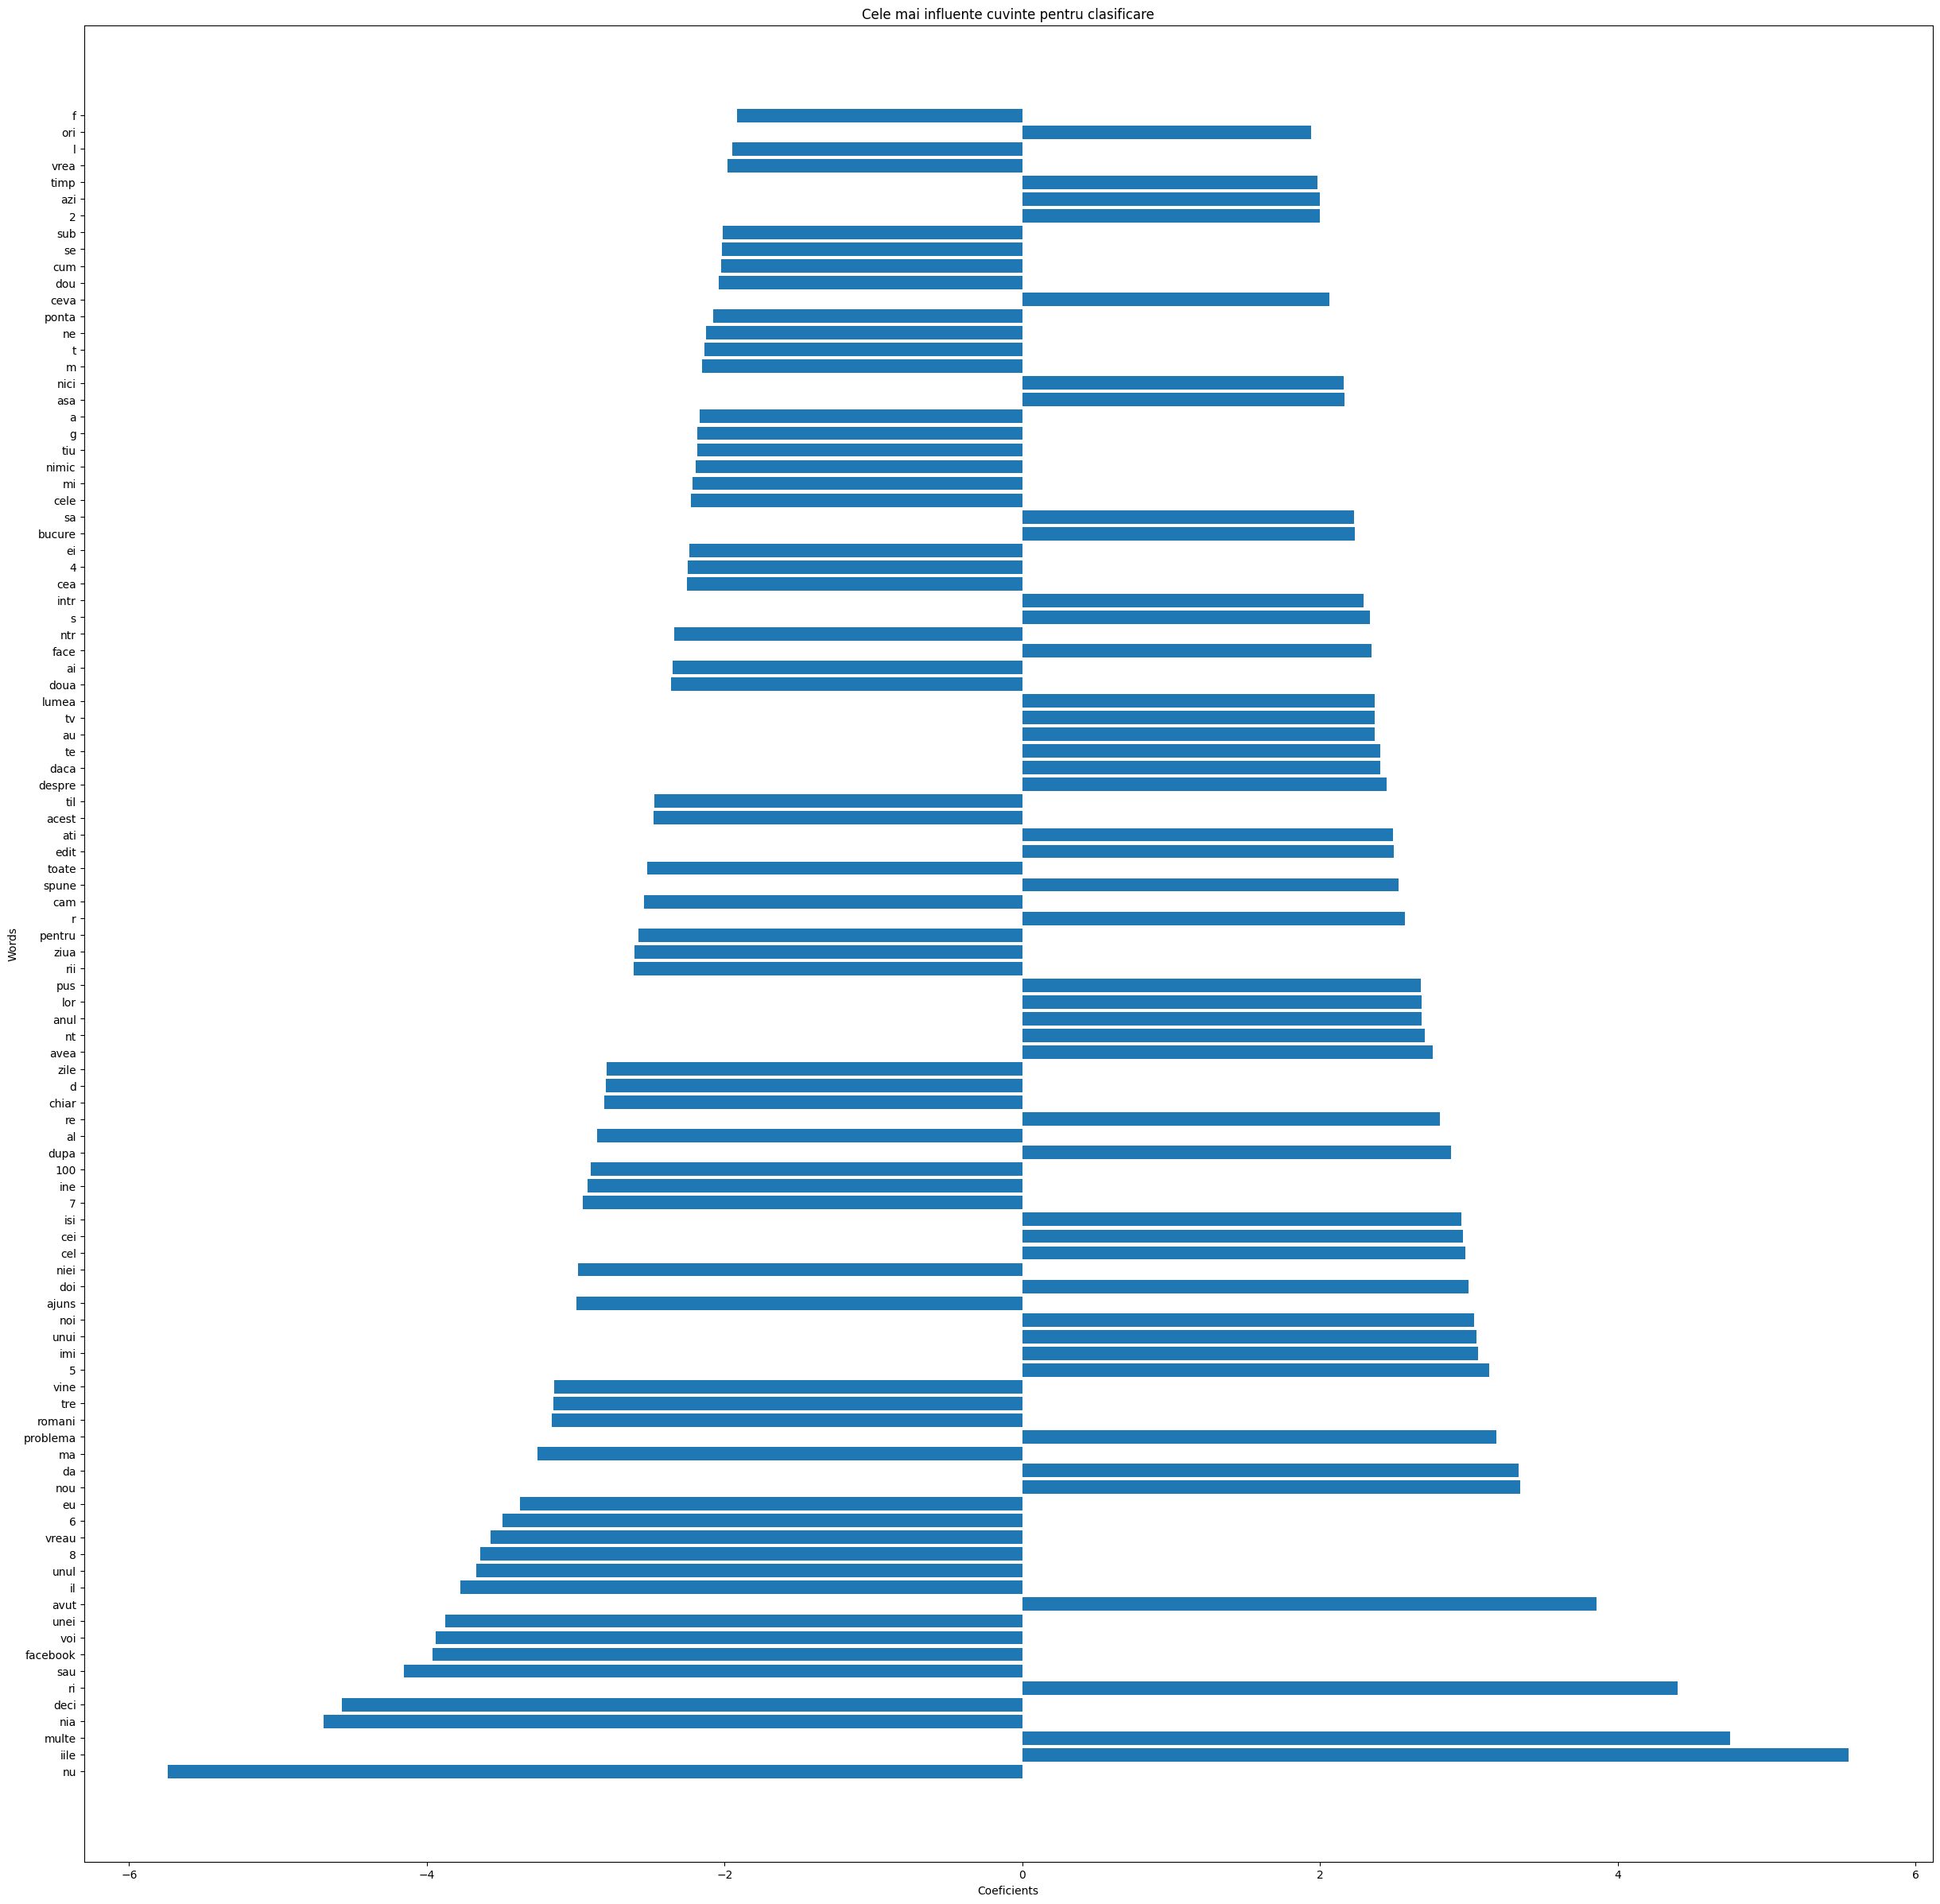

In [ ]:
weights = clf.coef_[0]

# Get the words corresponding to the embeddings.
words = fasttext_model.wv.index_to_key

# Create a dataframe of weights and words.
influential_words_df = pd.DataFrame(list(zip(words, weights)), columns=['words', 'weights'])

# for some examples in the test set, print the words with the highest weights
for i in range(10):
  print("Example ", i)
  print("Label: ", labels_test[i])
  print("Prediction: ", predictions_test[i])
  print("Text: ", contents_test[i])
  print("Words with highest weights: ")
  # print weight for each word
  print(influential_words_df[influential_words_df['words'].isin(contents_test_tokenized[i])].sort_values(by='weights', ascending=False))
  print("\n")

# Sort the DataFrame by the absolute values of weights for better visualization
influential_words_df['abs_weights'] = influential_words_df['weights'].abs()
influential_words_df = influential_words_df.sort_values(by='abs_weights', ascending=False)

# Plot the dataframe.
plt.figure(figsize=(30, 30))
plt.barh(influential_words_df['words'][:100], influential_words_df['weights'][:100])
plt.title('Cele mai influente cuvinte pentru clasificare')
plt.xlabel('Coeficients')
plt.ylabel('Words')
plt.show()